In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)
random.seed(123)

# Create parameters

In [3]:
alpha = 1 # proximal term coefficient
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

num_agents = num_commodities = 100

filename = "local_mcf_N%d_%.2f_n%d"%(num_points, eps_sublevel, num_agents)

In [4]:
num_vertices = 15
num_edges = 100

params, A_ineq, b_ineq = mra.mcf_data(num_vertices, num_edges, num_commodities)

In [5]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [6]:
true_x, true_f, true_lamb = mra.centralized_multi_commodity_flow(params, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-127.24864071513177


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.9999999999760267

In [8]:
true_lamb.shape, true_x.shape

((100, 1), (10000, 1))

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions(lamb_k, i, params[i], 
                                                                           eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions_noisy_prices(lamb_k, i, params[i], percent=percent, K=K)]

fun_obj_val = lambda x_k: mra.mcf_obj_value(x_k, params)

# Localization

In [10]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [11]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=150, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=150, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)

/Users/parshakova.tanya/opt/anaconda3/envs/osbdo/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/parshakova.tanya/Documents/projects/mra_precovery/mra/localization_prim_rec.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=7.2274E-01,  f_subopt_mra=6.3609E-01,  viol_xk=3.3057E+02, viol_mra=3.1778E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=6.2898E-02,  f_subopt_mra=4.4220E-02,  viol_xk=5.7256E+01, viol_mra=1.8167E+01, lamb_rel_diff=4.8992E-02
epoch=100, f_subopt_xk=4.6108E-03,  f_subopt_mra=4.1283E-03,  viol_xk=3.9126E+01, viol_mra=2.2572E+01, lamb_rel_diff=3.5822E-02
epoch=149, f_subopt_xk=3.4772E-04,  f_subopt_mra=1.9313E-03,  viol_xk=4.2906E+01, viol_mra=3.2218E+01, lamb_rel_diff=3.5059E-02
epoch=0, f_subopt_xk=7.2274E-01,  f_subopt_mra=6.9873E-01,  viol_xk=3.3057E+02, viol_mra=3.2738E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=6.2898E-02,  f_subopt_mra=4.3230E-02,  viol_xk=5.7256E+01, viol_mra=2.4702E+01, lamb_rel_diff=4.8992E-02
epoch=100, f_subopt_xk=4.6108E-03,  f_subopt_mra=9.6324E-04,  viol_xk=3.9126E+01, viol_mra=2.6310E+00, lamb_rel_diff=3.5822E-02
epoch=149, f_subopt_xk=3.4772E-04,  f_subopt_mra=3.0021E-03,  viol_xk=4.2906E+01, viol_mra=1.2946E+00, lamb_rel_diff=3.5059E

In [9]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [10]:
T = 150
for iter in range(2):
    if iter == 0:
        idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[1:]) + 1
        idx_paverage = np.argmin(np.array(all_res["viol_primal_paver_xk"])[1:]) + 1
        idx_noisy_y = np.argmin(np.array(all_results_noisy_y["viol_primal_mra_xk"][1:])) + 1
        idx_eps = np.argmin(np.array(all_results_eps["viol_primal_mra_xk"])[1:]) + 1
    else:
        idx_xk=0
        idx_paverage=0
        idx_noisy_y=0
        idx_eps=0

    print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

    print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
        "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
        "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
        "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
        "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

    print("xk", np.array(all_res["viol_primal_xk"])[idx_xk] / b_norm,
        "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps] / b_norm,
        "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y] / b_norm,
        "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage] / b_norm,)

idx_xk=143, idx_eps=62, idx_noisy_y=137, idx_paverage=149
xk 0.0012404410352758071 sub_eps 0.017860075041410753 noisy_y 0.0014048067094479093 proj 0.6700951402831694 paverage 0.16143828938888286
xk 0.7867528056315033 sub_eps 0.27830791636259344 noisy_y 3.2183266249051677e-07 paverage 2.5825285253366643
idx_xk=0, idx_eps=0, idx_noisy_y=0, idx_paverage=0
xk 0.7227366198313797 sub_eps 0.6360868010378592 noisy_y 0.6987322070833901 proj 0.6700951402831694 paverage 0.7227366198313797
xk 0.0 sub_eps 0.0 noisy_y 0.0 paverage 0.0


In [21]:
np.array(all_res["viol_primal_xk"])[idx_xk] / all_results_eps["viol_primal_mra_xk"][idx_eps]

2.826914936212172

In [22]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
# res["eps"].keys()

In [7]:
import pickle

with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)

all_results_eps, all_results_noisy_y = res["eps"], res["noisy_y"]
T = 150

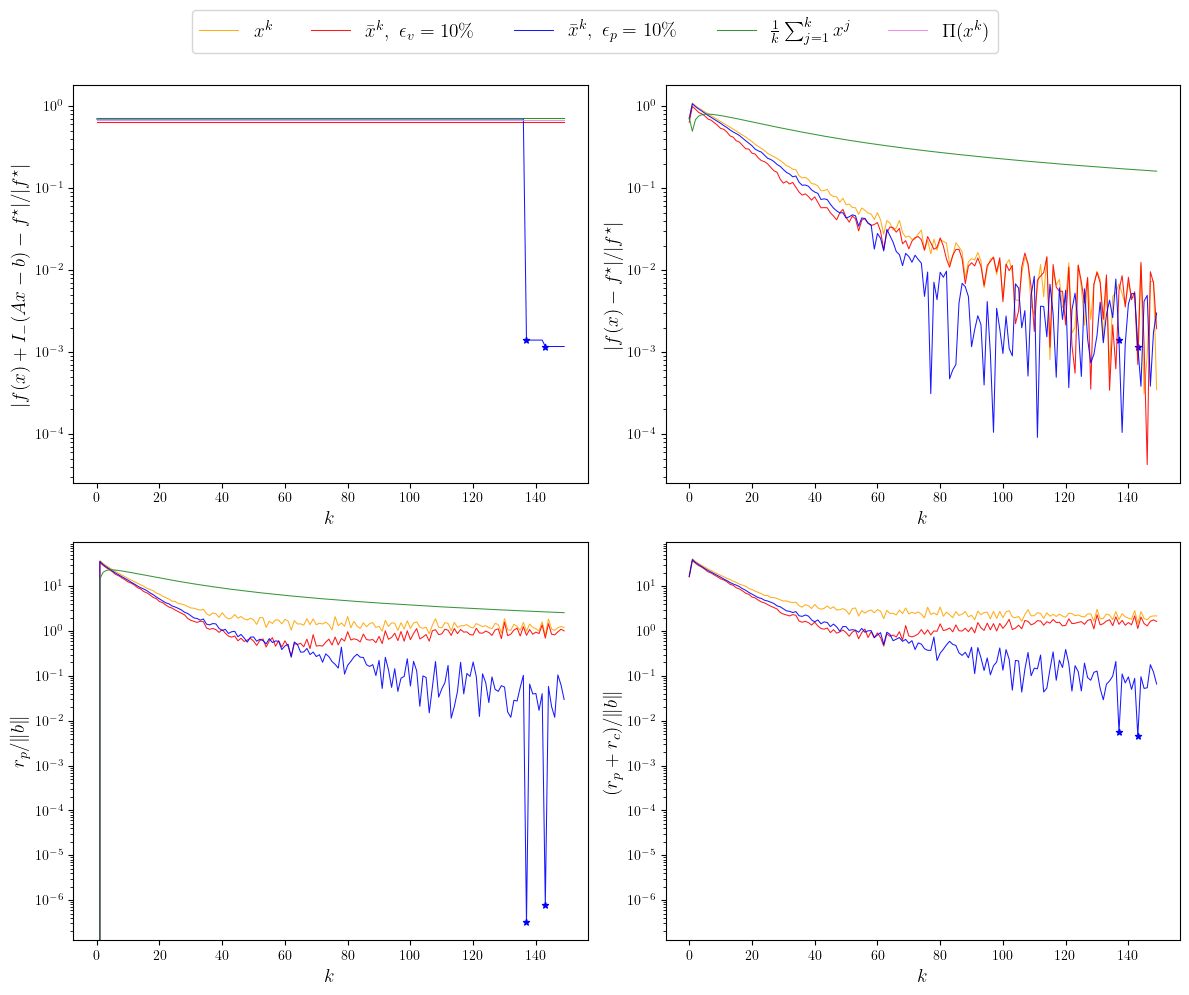

In [8]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T=150)